## Setup

In [15]:
try:
    import torch
    if torch.cuda.is_available():
        print(f"PyTorch CUDA dostępna. Liczba GPU: {torch.cuda.device_count()}")
        print(f"Nazwa GPU: {torch.cuda.get_device_name(0)}")
    else:
        print("PyTorch CUDA niedostępna. Obliczenia będą wykonywane na CPU.")
except ImportError:
    print("PyTorch nie jest zainstalowany. Nie można sprawdzić statusu CUDA.")

PyTorch CUDA dostępna. Liczba GPU: 1
Nazwa GPU: NVIDIA GeForce RTX 3090


In [16]:
# ## Import Bibliotek
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import stanza
from collections import Counter
import re

from spacytextblob.spacytextblob import SpacyTextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC # Przykładowy klasyfikator SVM
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

# Ustawienia wizualizacji
# %matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100 # Lepsza rozdzielczość wykresów
# -

# ## Wczytanie i Przygotowanie Danych (Wspólne dla Zadań 2-4)

# +
DATASET_PATH = 'twitter_dataset.csv' # Upewnij się, że plik jest w tym samym folderze
TWEET_COLUMN = 'Text' # Kolumna z treścią tweetów

## Ładowanie danych

In [17]:
try:
    df_tweets = pd.read_csv(DATASET_PATH)
    print(f"Wczytano dane z {DATASET_PATH}. Liczba tweetów: {len(df_tweets)}")
    print("Pierwsze 5 wierszy:")
    print(df_tweets.head())
    print("\nInformacje o danych:")
    df_tweets.info()

    # Podstawowe czyszczenie - usunięcie wierszy bez tekstu tweeta
    initial_rows = len(df_tweets)
    df_tweets.dropna(subset=[TWEET_COLUMN], inplace=True)
    if len(df_tweets) < initial_rows:
        print(f"\nUsunięto {initial_rows - len(df_tweets)} wierszy z brakującą wartością w kolumnie '{TWEET_COLUMN}'.")

    # Proste czyszczenie tekstu (opcjonalne, można rozbudować)
    def clean_text(text):
        text = re.sub(r'http\S+', '', text) # Usuń linki
        text = re.sub(r'@\w+', '', text) # Usuń wzmianki
        text = re.sub(r'#\w+', '', text) # Usuń hashtagi (można zachować, zależy od celu)
        text = re.sub(r'\s+', ' ', text).strip() # Usuń nadmiarowe białe znaki
        return text

    # Zastosuj czyszczenie jeśli potrzebne - UWAGA: może wpłynąć na NER/Sentyment
    # df_tweets['cleaned_text'] = df_tweets[TWEET_COLUMN].apply(clean_text)
    # TEXT_TO_ANALYZE = 'cleaned_text' # Używaj oczyszczonego tekstu
    TEXT_TO_ANALYZE = TWEET_COLUMN # Używaj oryginalnego tekstu

except FileNotFoundError:
    print(f"BŁĄD: Plik {DATASET_PATH} nie został znaleziony. Upewnij się, że znajduje się w odpowiednim folderze.")
    # Utwórz pusty DataFrame, aby uniknąć błędów w dalszej części notebooka
    df_tweets = pd.DataFrame(columns=['Tweet_ID', 'Username', 'Text', 'Retweets', 'Likes', 'Timestamp'])
except Exception as e:
    print(f"Wystąpił nieoczekiwany błąd podczas wczytywania danych: {e}")
    df_tweets = pd.DataFrame(columns=['Tweet_ID', 'Username', 'Text', 'Retweets', 'Likes', 'Timestamp'])


Wczytano dane z twitter_dataset.csv. Liczba tweetów: 10000
Pierwsze 5 wierszy:
   Tweet_ID        Username  \
0         1         julie81   
1         2   richardhester   
2         3  williamsjoseph   
3         4     danielsmary   
4         5      carlwarren   

                                                Text  Retweets  Likes  \
0  Party least receive say or single. Prevent pre...         2     25   
1  Hotel still Congress may member staff. Media d...        35     29   
2  Nice be her debate industry that year. Film wh...        51     25   
3  Laugh explain situation career occur serious. ...        37     18   
4  Involve sense former often approach government...        27     80   

             Timestamp  
0  2023-01-30 11:00:51  
1  2023-01-02 22:45:58  
2  2023-01-18 11:25:19  
3  2023-04-10 22:06:29  
4  2023-01-24 07:12:21  

Informacje o danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column     

# [DATASET](https://www.kaggle.com/datasets/goyaladi/twitter-dataset?resource=download&select=twitter_dataset.csv) 

## Zadanie 2: Analiza Sentymentu Tweetów przy użyciu spaCy

**Cel:**  
Wykorzystaj bibliotekę spaCy do przeprowadzenia analizy sentymentu pobranych tweetów.

**Kroki:**
- Wczytaj dane z pliku uzyskane w Zadaniu 1.
- Zaimplementuj analizę sentymentu tweetów. Możesz:
  - Zastosować gotowy model lub rozszerzyć pipeline spaCy o dodatkowe reguły,
  - Alternatywnie, połączyć spaCy z innymi narzędziami (np. TextBlob) dla oceny sentymentu.
- Przypisz każdemu tweetowi etykietę: **pozytywny**, **neutralny** lub **negatywny**.
- Zwizualizuj wyniki, np.:
  - Wykres kołowy przedstawiający procentowy rozkład sentymentu.
  - Wykres słupkowy z liczbą tweetów dla każdej kategorii.

In [30]:
# Pobieranie modelu spaCy dla języka polskiego (jeśli nie ma)
SPACY_MODEL_NAME = "en_core_web_lg"

# SPACY_MODEL_NAME = "pl_core_news_lg"
try:
    nlp_spacy = spacy.load(SPACY_MODEL_NAME)
    print(f"Model spaCy '{SPACY_MODEL_NAME}' załadowany.")
except OSError:
    print(f"Model spaCy '{SPACY_MODEL_NAME}' nie znaleziony. Pobieranie...")
    try:
        spacy.cli.download(SPACY_MODEL_NAME)
        nlp_spacy = spacy.load(SPACY_MODEL_NAME)
        print(f"Model spaCy '{SPACY_MODEL_NAME}' pobrany i załadowany.")
    except Exception as e:
        print(f"Błąd podczas pobierania modelu spaCy: {e}")
        nlp_spacy = None # Ustaw na None, jeśli ładowanie się nie powiodło

Model spaCy 'en_core_web_lg' załadowany.


In [31]:
# Dodanie spacytextblob do potoku spaCy
if nlp_spacy:
    # Sprawdź, czy potok już istnieje, aby uniknąć błędu przy ponownym uruchomieniu komórki
    if 'spacytextblob' not in nlp_spacy.pipe_names:
        try:
            nlp_spacy.add_pipe('spacytextblob')
            print("Dodano 'spacytextblob' do potoku spaCy.")
        except Exception as e:
            print(f"Błąd podczas dodawania 'spacytextblob' do potoku: {e}")
            # Możliwe, że komponent jest już zarejestrowany, ale nie w tym obiekcie nlp
            # Próba utworzenia nowego obiektu pipeline może pomóc w niektórych przypadkach
            # nlp_spacy.add_pipe(SpacyTextBlob(nlp_spacy.vocab)) # Alternatywa jeśli standardowe dodawanie zawiedzie
    else:
        print("'spacytextblob' już istnieje w potoku spaCy.")


# Funkcja do analizy sentymentu z użyciem spacytextblob
def spacy_sentiment_textblob(text):
    if not nlp_spacy or pd.isna(text) or 'spacytextblob' not in nlp_spacy.pipe_names:
        return "neutralny" # Wartość domyślna/błąd

    try:
        doc = nlp_spacy(str(text))
        polarity = doc._.blob.polarity # Zakres: -1.0 (negatywny) do +1.0 (pozytywny)

        # Definicja progów dla etykiet
        if polarity > 0.1:   # Próg dla pozytywnego sentymentu
            return "pozytywny"
        elif polarity < -0.1: # Próg dla negatywnego sentymentu
            return "negatywny"
        else:
            return "neutralny" # Blisko zera traktujemy jako neutralny
    except Exception as e:
        # print(f"Błąd podczas analizy sentymentu TextBlob dla tekstu: {text[:50]}... Błąd: {e}")
        return "neutralny" # Zwróć neutralny w razie błędu przetwarzania


Dodano 'spacytextblob' do potoku spaCy.



Rozpoczynanie analizy sentymentu spaCy (TextBlob - Angielski Leksykon)...
Analiza sentymentu spaCy (TextBlob) zakończona.

Rozkład sentymentu (spaCy - TextBlob):
spacy_sentiment
neutralny    4852
pozytywny    4638
negatywny     510
Name: count, dtype: int64

Wizualizacja rozkładu sentymentu (spaCy - TextBlob):


C:\Users\Jan\AppData\Local\Temp\ipykernel_4404\3565222905.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], x='spacy_sentiment', data=df_tweets_analysis, palette=['#66c2a5','#fc8d62','#8da0cb'], order=sentiment_counts_spacy.index)


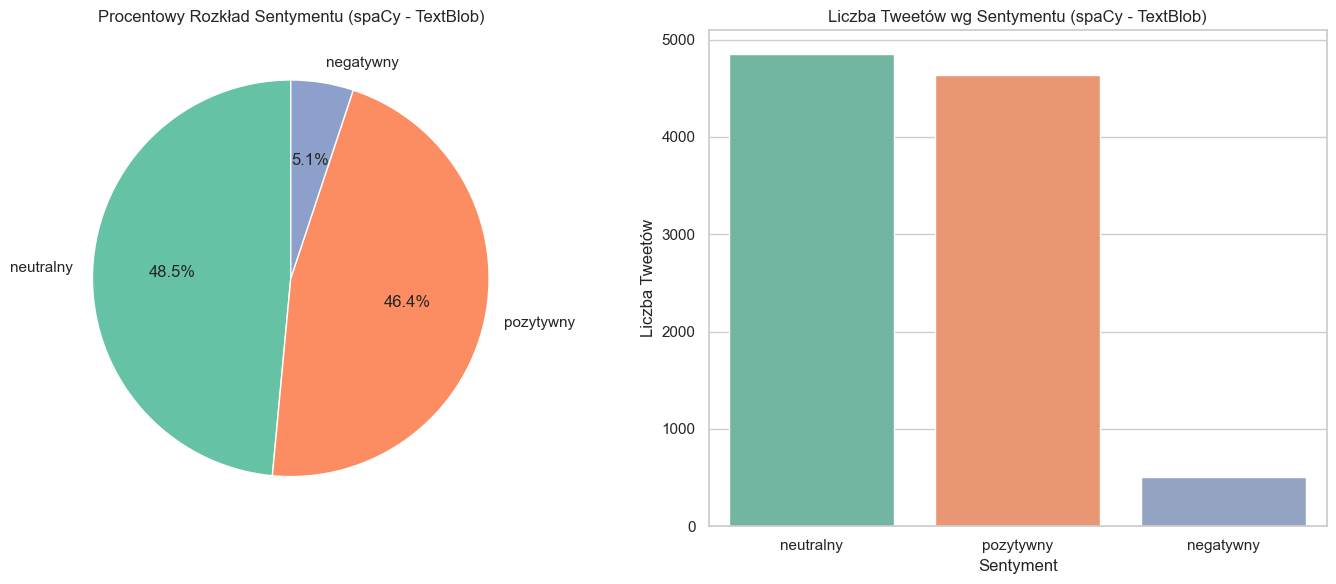

In [32]:
df_tweets_analysis = df_tweets.copy()

if nlp_spacy and 'spacytextblob' in nlp_spacy.pipe_names and not df_tweets_analysis.empty:
    print("\nRozpoczynanie analizy sentymentu spaCy (TextBlob - Angielski Leksykon)...")
    df_tweets_analysis['spacy_sentiment'] = df_tweets_analysis[TEXT_TO_ANALYZE].apply(spacy_sentiment_textblob)
    print("Analiza sentymentu spaCy (TextBlob) zakończona.")
    print("\nRozkład sentymentu (spaCy - TextBlob):")
    print(df_tweets_analysis['spacy_sentiment'].value_counts())
else:
    print("\nNie można przeprowadzić analizy sentymentu spaCy (TextBlob) - model niezaładowany, brak komponentu 'spacytextblob' lub brak danych.")
    if 'spacy_sentiment' not in df_tweets_analysis.columns:
         df_tweets_analysis['spacy_sentiment'] = "b/d" # brak danych

# Wizualizacja wyników spaCy (TextBlob)
if 'spacy_sentiment' in df_tweets_analysis.columns and df_tweets_analysis['spacy_sentiment'].nunique() > 1 :
    print("\nWizualizacja rozkładu sentymentu (spaCy - TextBlob):")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sentiment_counts_spacy = df_tweets_analysis['spacy_sentiment'].value_counts()
    axes[0].pie(sentiment_counts_spacy, labels=sentiment_counts_spacy.index, autopct='%1.1f%%', startangle=90, colors=['#66c2a5','#fc8d62','#8da0cb'])
    axes[0].set_title('Procentowy Rozkład Sentymentu (spaCy - TextBlob)')

    sns.countplot(ax=axes[1], x='spacy_sentiment', data=df_tweets_analysis, palette=['#66c2a5','#fc8d62','#8da0cb'], order=sentiment_counts_spacy.index)
    axes[1].set_title('Liczba Tweetów wg Sentymentu (spaCy - TextBlob)')
    axes[1].set_xlabel('Sentyment')
    axes[1].set_ylabel('Liczba Tweetów')

    plt.tight_layout()
    plt.show()
else:
     print("\nNie można wygenerować wizualizacji dla sentymentu spaCy (TextBlob) (brak danych lub tylko jedna kategoria).")


## Zadanie 3: Analiza Językowa i Sentymentu przy użyciu Stanza

**Cel:**  
Przeprowadź analizę językową tweetów oraz oblicz sentyment przy użyciu biblioteki Stanza.

**Kroki:**
- Wczytaj te same dane tweetów.
- Użyj Stanza do:
  - Lematizacji tweetów,
  - Analizy składniowej (wyznaczenie rdzenia zdania, części mowy itp.).
- Oblicz sentyment tweetów korzystając z dostępnych narzędzi lub własnych reguł.
- Porównaj wyniki sentymentu uzyskane przy użyciu Stanza z wynikami z Zadania 2 (spaCy).
- Zwizualizuj porównanie wyników (np. wykresy porównawcze).


In [33]:
STANZA_LANG = 'en'
try:
    stanza.download(STANZA_LANG, verbose=False)
    print(f"\nŁadowanie pipeline Stanza dla języka '{STANZA_LANG}'...")
    use_gpu_flag = False
    try:
        import torch
        if torch.cuda.is_available():
            use_gpu_flag = True
    except ImportError: pass
    stanza_nlp = stanza.Pipeline(STANZA_LANG, use_gpu=use_gpu_flag, verbose=False)
    print(f"Pipeline Stanza załadowany. GPU: {use_gpu_flag}")
except Exception as e:
    print(f"Błąd podczas inicjalizacji Stanza: {e}")
    stanza_nlp = None

def analyze_linguistic_stanza(text):
    if not stanza_nlp or pd.isna(text): return {"lemmas": [], "pos_tags": [], "dependencies": [], "sentiment_raw": None}
    doc = stanza_nlp(str(text))
    analysis = {"lemmas": [], "pos_tags": [], "dependencies": [], "sentiment_raw": []}
    for sentence in doc.sentences:
        analysis["sentiment_raw"].append(sentence.sentiment)
        for word in sentence.words:
            analysis["lemmas"].append(word.lemma)
            analysis["pos_tags"].append(f"{word.text} ({word.upos})")
            head_word = sentence.words[word.head-1].text if word.head > 0 else "ROOT"
            analysis["dependencies"].append(f"{word.text} --{word.deprel}--> {head_word}")
    return analysis

def get_stanza_sentiment_label(text):
    if not stanza_nlp or pd.isna(text): return "neutralny"
    doc = stanza_nlp(str(text))
    sentiments = [sentence.sentiment for sentence in doc.sentences]
    if not sentiments: return "neutralny"
    avg_sentiment = sum(sentiments) / len(sentiments)
    if avg_sentiment > 1.2: return "pozytywny"
    elif avg_sentiment < 0.8: return "negatywny"
    else: return "neutralny"



Ładowanie pipeline Stanza dla języka 'en'...
Pipeline Stanza załadowany. GPU: True


In [ ]:
#Stanza analiza
if stanza_nlp and not df_tweets_analysis.empty:
    print("\nRozpoczynanie analizy lingwistycznej i sentymentu Stanza...")
    if 'stanza_sentiment' not in df_tweets_analysis.columns: # Wykonaj tylko jeśli kolumna nie istnieje
        df_tweets_analysis['stanza_sentiment'] = df_tweets_analysis[TEXT_TO_ANALYZE].apply(get_stanza_sentiment_label)
        print("Analiza sentymentu Stanza zakończona.")
    else:
        print("Kolumna 'stanza_sentiment' już istnieje. Pomijam ponowne obliczanie.")

    print("\nRozkład sentymentu (Stanza):")
    print(df_tweets_analysis['stanza_sentiment'].value_counts())

    # Przykład pełnej analizy dla pierwszego tweeta
    if len(df_tweets_analysis) > 0:
        print("\nPrzykład pełnej analizy lingwistycznej Stanza dla pierwszego tweeta:")
        first_tweet_text = df_tweets_analysis[TEXT_TO_ANALYZE].iloc[0]
        stanza_linguistic_example = analyze_linguistic_stanza(first_tweet_text)
        print(f"Tweet: {first_tweet_text}")
        print(f"Lematy: {' '.join(stanza_linguistic_example.get('lemmas', []))}")
        # print(f"Tagi POS: {stanza_linguistic_example.get('pos_tags', [])}") # Może być długie
        # print(f"Zależności: {stanza_linguistic_example.get('dependencies', [])}") # Może być długie
        print(f"Surowy sentyment Stanza (zdania): {stanza_linguistic_example.get('sentiment_raw', [])}")
        print(f"Ogólny sentyment Stanza (etykieta): {df_tweets_analysis['stanza_sentiment'].iloc[0]}")


else:
    print("\nNie można przeprowadzić analizy Stanza - pipeline niezaładowany lub brak danych.")
    if 'stanza_sentiment' not in df_tweets_analysis.columns:
        df_tweets_analysis['stanza_sentiment'] = "b/d"


Rozpoczynanie analizy lingwistycznej i sentymentu Stanza...



Porównanie wyników analizy sentymentu (spaCy/TextBlob [EN] vs Stanza [EN]):
Stanza (EN)            negatywny  neutralny  pozytywny
spaCy (TextBlob - EN)                                 
negatywny                    134        360         16
neutralny                    732       3834        286
pozytywny                    386       3500        752

Wizualizacja porównania sentymentu:


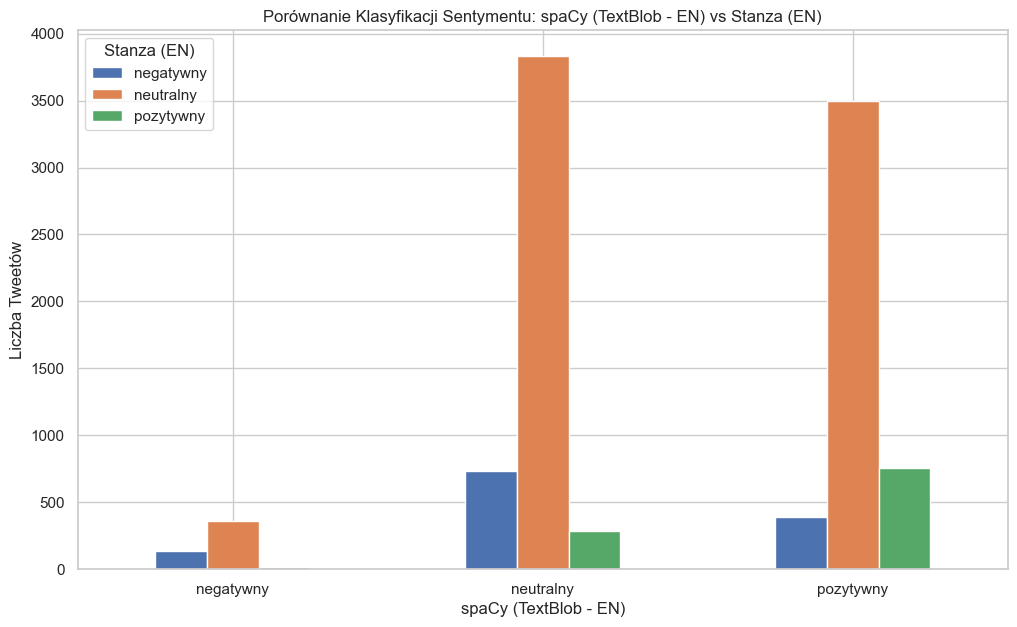

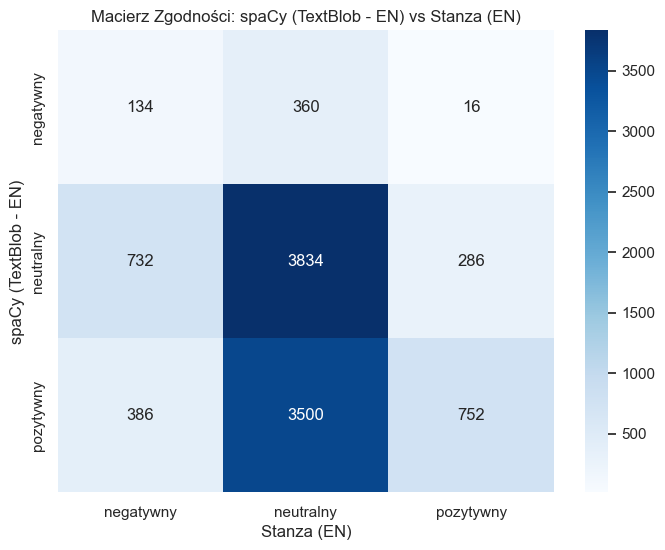

In [26]:
if 'spacy_sentiment' in df_tweets_analysis.columns and 'stanza_sentiment' in df_tweets_analysis.columns and \
   df_tweets_analysis['spacy_sentiment'].nunique() > 1 and df_tweets_analysis['stanza_sentiment'].nunique() > 1:

    print("\nPorównanie wyników analizy sentymentu (spaCy/TextBlob [EN] vs Stanza [EN]):")
    # Zmieniono tytuł wiersza dla jasności
    comparison_table = pd.crosstab(df_tweets_analysis['spacy_sentiment'], df_tweets_analysis['stanza_sentiment'],
                                   rownames=['spaCy (TextBlob - EN)'], colnames=['Stanza (EN)'])
    print(comparison_table)

    print("\nWizualizacja porównania sentymentu:")
    comparison_table.plot(kind='bar', figsize=(12, 7), rot=0)
    plt.title('Porównanie Klasyfikacji Sentymentu: spaCy (TextBlob - EN) vs Stanza (EN)')
    plt.ylabel('Liczba Tweetów')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(comparison_table, annot=True, fmt="d", cmap="Blues")
    plt.title('Macierz Zgodności: spaCy (TextBlob - EN) vs Stanza (EN)')
    plt.show()
else:
    print("\nNie można wygenerować porównania sentymentu (brak wyników z obu metod lub zbyt mało kategorii).")


## Zadanie 4: Rozpoznawanie Encji Nazwanych (NER)

### **Cel:** Wykonanie NER na tweetach za pomocą Stanza i spaCy oraz porównanie wyników. (Logika tej części pozostaje bez zmian, używa tych samych modeli co wcześniej: Stanza `en` i spaCy `en_core_news_lg`).


In [27]:
# Stanza NER
def extract_stanza_ner(text):
    if not stanza_nlp or pd.isna(text): return []
    try:
        doc = stanza_nlp(str(text))
        entities = [(ent.text, ent.type) for ent in doc.ents]
        return entities
    except Exception as e: return []

if stanza_nlp and not df_tweets_analysis.empty:
    print("\nRozpoczynanie NER przy użyciu Stanza...")
    if 'stanza_ner' not in df_tweets_analysis.columns: # Wykonaj tylko jeśli nie ma
         df_tweets_analysis['stanza_ner'] = df_tweets_analysis[TEXT_TO_ANALYZE].apply(extract_stanza_ner)
         print("NER Stanza zakończony.")
    else:
         print("Kolumna 'stanza_ner' już istnieje. Pomijam.")
    stanza_ner_counts = Counter()
    df_tweets_analysis['stanza_ner'].apply(lambda ents: stanza_ner_counts.update(ent[1] for ent in ents))
    print("\nTypy i liczba encji znalezionych przez Stanza:")
    print(stanza_ner_counts)
else:
    print("\nNie można przeprowadzić NER Stanza.")
    if 'stanza_ner' not in df_tweets_analysis.columns: df_tweets_analysis['stanza_ner'] = [[] for _ in range(len(df_tweets_analysis))]



Rozpoczynanie NER przy użyciu Stanza...
NER Stanza zakończony.

Typy i liczba encji znalezionych przez Stanza:
Counter({'CARDINAL': 4130, 'NORP': 1159, 'DATE': 1030, 'ORDINAL': 1006, 'TIME': 938, 'ORG': 435, 'PERSON': 166, 'LOC': 37, 'MONEY': 21, 'QUANTITY': 9, 'LANGUAGE': 1, 'WORK_OF_ART': 1})


In [28]:
# Spacy NER
def extract_spacy_ner(text):
    if not nlp_spacy or pd.isna(text): return []
    try:
        doc = nlp_spacy(str(text))
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        return entities
    except Exception as e: return []

if nlp_spacy and not df_tweets_analysis.empty:
    print("\nRozpoczynanie NER przy użyciu spaCy...")
    if 'spacy_ner' not in df_tweets_analysis.columns: # Wykonaj tylko jeśli nie ma
        df_tweets_analysis['spacy_ner'] = df_tweets_analysis[TEXT_TO_ANALYZE].apply(extract_spacy_ner)
        print("NER spaCy zakończony.")
    else:
        print("Kolumna 'spacy_ner' już istnieje. Pomijam.")

    spacy_ner_counts = Counter()
    df_tweets_analysis['spacy_ner'].apply(lambda ents: spacy_ner_counts.update(ent[1] for ent in ents))
    print("\nTypy i liczba encji znalezionych przez spaCy:")
    print(spacy_ner_counts)
else:
    print("\nNie można przeprowadzić NER spaCy.")
    if 'spacy_ner' not in df_tweets_analysis.columns: df_tweets_analysis['spacy_ner'] = [[] for _ in range(len(df_tweets_analysis))]


Rozpoczynanie NER przy użyciu spaCy...
NER spaCy zakończony.

Typy i liczba encji znalezionych przez spaCy:
Counter({'CARDINAL': 3928, 'DATE': 1435, 'NORP': 1177, 'ORDINAL': 960, 'TIME': 921, 'ORG': 802, 'PERSON': 564, 'LOC': 92, 'GPE': 69, 'PRODUCT': 44, 'EVENT': 42, 'WORK_OF_ART': 13, 'QUANTITY': 8, 'MONEY': 5, 'LANGUAGE': 5, 'FAC': 1, 'LAW': 1})



--- Porównanie liczby znalezionych encji wg typów ---
             spaCy  Stanza
CARDINAL      3928    4130
DATE          1435    1030
EVENT           42       0
FAC              1       0
GPE             69       0
LANGUAGE         5       1
LAW              1       0
LOC             92      37
MONEY            5      21
NORP          1177    1159
ORDINAL        960    1006
ORG            802     435
PERSON         564     166
PRODUCT         44       0
QUANTITY         8       9
TIME           921     938
WORK_OF_ART     13       1


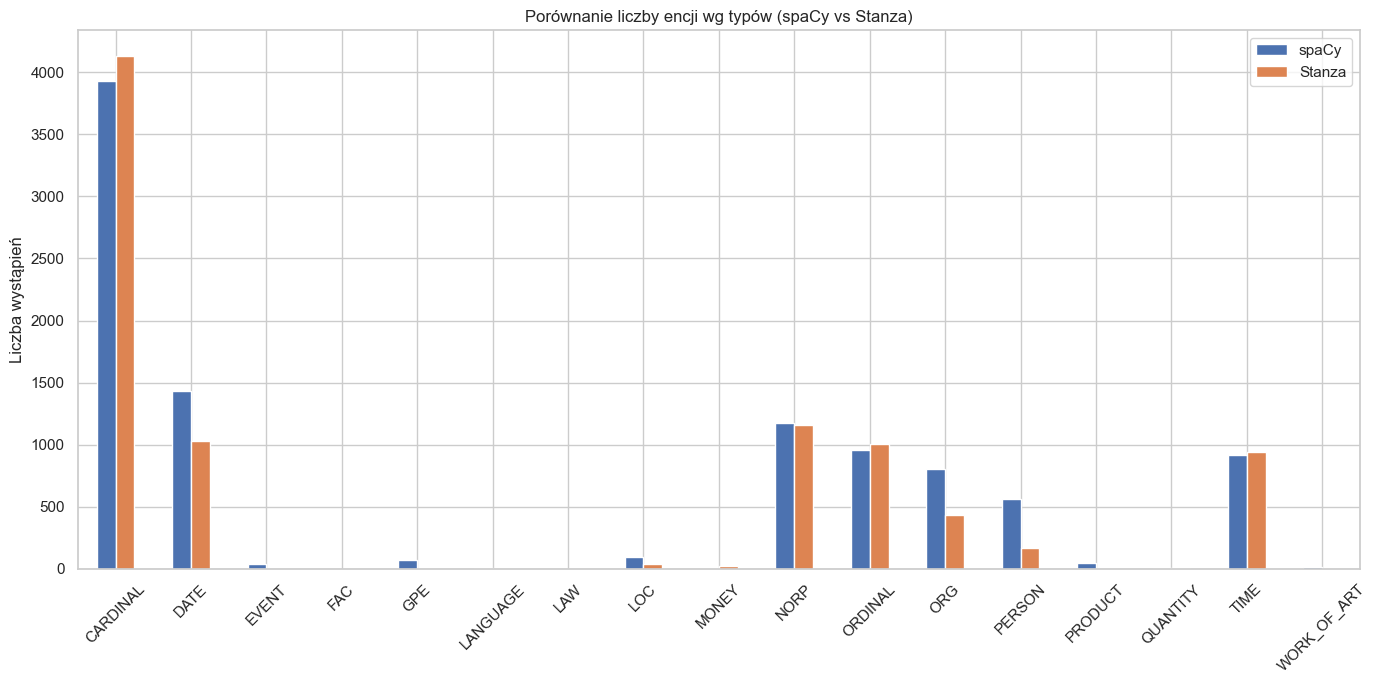

In [29]:
if 'spacy_ner_counts' in locals() and 'stanza_ner_counts' in locals() and (spacy_ner_counts or stanza_ner_counts):
    print("\n--- Porównanie liczby znalezionych encji wg typów ---")
    df_ner_compare = pd.DataFrame({
        'spaCy': pd.Series(spacy_ner_counts),
        'Stanza': pd.Series(stanza_ner_counts)
    }).fillna(0).astype(int)
    print(df_ner_compare)
    df_ner_compare.plot(kind='bar', figsize=(14, 7), rot=45)
    plt.title('Porównanie liczby encji wg typów (spaCy vs Stanza)')
    plt.ylabel('Liczba wystąpień')
    plt.tight_layout()
    plt.show()
else:
    print("\nNie można wygenerować porównania NER (brak wyników).")


## Zadanie 5: Klasyfikacja Sentymentu na Innym Datasetcie oraz Dodatkowy Proces NER


In [39]:
OTHER_DATASET_PATH = 'twitter_training.csv'
OTHER_TEXT_COLUMN = 'text'
OTHER_SENTIMENT_COLUMN = 'sentiment'

try:
    df_other = pd.read_csv(OTHER_DATASET_PATH)
    print(f"Wczytano dane z {OTHER_DATASET_PATH}. Liczba wpisów: {len(df_other)}")
    
    #Dataprep
    current_col = df_other.columns.tolist()

    df_other.loc[-1] = current_col
    df_other.index = df_other.index+1
    df_other = df_other.sort_index()

    df_other.columns = ['tweet_id','entity','sentiment','text']

    df_other.reset_index(drop=True,inplace=True)
    
    if OTHER_TEXT_COLUMN not in df_other.columns or OTHER_SENTIMENT_COLUMN not in df_other.columns: raise ValueError(f"Brak wymaganych kolumn ('{OTHER_TEXT_COLUMN}', '{OTHER_SENTIMENT_COLUMN}')")
    df_other.dropna(subset=[OTHER_TEXT_COLUMN, OTHER_SENTIMENT_COLUMN], inplace=True)
    print(f"Dane po usunięciu NaN: {len(df_other)} wpisów.")
except FileNotFoundError: print(f"BŁĄD: Plik {OTHER_DATASET_PATH} nie został znaleziony."); df_other = pd.DataFrame()
except ValueError as ve: print(f"BŁĄD: {ve}"); df_other = pd.DataFrame()
except Exception as e: print(f"Wystąpił błąd: {e}"); df_other = pd.DataFrame()


if not df_other.empty:
    print("\nPrzykładowe dane z nowego datasetu:")
    print(df_other.head())
    print(f"\nUnikalne etykiety sentymentu: {df_other[OTHER_SENTIMENT_COLUMN].unique()}")
    sentiment_map = {'pozytywny': 2, 'neutralny': 1, 'negatywny': 0}
    if df_other[OTHER_SENTIMENT_COLUMN].dtype == 'object':
         if all(item in sentiment_map for item in df_other[OTHER_SENTIMENT_COLUMN].unique()):
              print("\nMapowanie etykiet tekstowych na numeryczne")
              df_other['sentiment_numeric'] = df_other[OTHER_SENTIMENT_COLUMN].map(sentiment_map)
              TARGET_COLUMN = 'sentiment_numeric'
         else:
              print("\nNie wszystkie etykiety pasują do mapy. Używam oryginalnych.")
              TARGET_COLUMN = OTHER_SENTIMENT_COLUMN
    else: TARGET_COLUMN = OTHER_SENTIMENT_COLUMN
    print(f"Kolumna docelowa: {TARGET_COLUMN}")
 

Wczytano dane z twitter_training.csv. Liczba wpisów: 74681
Dane po usunięciu NaN: 73996 wpisów.

Przykładowe dane z nowego datasetu:
  tweet_id       entity sentiment  \
0     2401  Borderlands  Positive   
1     2401  Borderlands  Positive   
2     2401  Borderlands  Positive   
3     2401  Borderlands  Positive   
4     2401  Borderlands  Positive   

                                                text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  

Unikalne etykiety sentymentu: ['Positive' 'Neutral' 'Negative' 'Irrelevant']

Nie wszystkie etykiety pasują do mapy. Używam oryginalnych.
Kolumna docelowa: sentiment


In [40]:
if not df_other.empty and TARGET_COLUMN in df_other.columns:
    print("\n--- Implementacja Klasyfikatora Sentymentu ---")
    X = df_other[OTHER_TEXT_COLUMN]
    y = df_other[TARGET_COLUMN]
    if len(df_other) > 10:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y if y.nunique() > 1 else None)
        print(f"Podzielono dane: {len(X_train)} trenujących, {len(X_test)} testowych.")
    else:
        print("Zbyt mało danych, używam całego zbioru do 'testowania'.")
        X_train, X_test, y_train, y_test = X, X, y, y

    text_classifier = Pipeline([('tfidf', TfidfVectorizer(max_features=5000)), ('clf', SVC(kernel='linear'))])
    print("Trenowanie klasyfikatora..."); text_classifier.fit(X_train, y_train); print("Trenowanie zakończone.")
    y_pred_custom = text_classifier.predict(X_test)
    print("\nWyniki własnego klasyfikatora (na zbiorze testowym):")
    accuracy = accuracy_score(y_test, y_pred_custom); print(f"Dokładność: {accuracy:.4f}")
    target_names_report = None
    if 'sentiment_map' in locals() and TARGET_COLUMN == 'sentiment_numeric':
         reverse_sentiment_map = {v: k for k, v in sentiment_map.items()}
         target_names_report = [reverse_sentiment_map[i] for i in sorted(y.unique())]
    print("Raport Klasyfikacji:\n", classification_report(y_test, y_pred_custom, target_names=target_names_report))
    df_test_results = pd.DataFrame({'text': X_test, 'true_sentiment': y_test, 'custom_classifier_pred': y_pred_custom})
else: print("\nNie można zaimplementować klasyfikatora.")


--- Implementacja Klasyfikatora Sentymentu ---
Podzielono dane: 51797 trenujących, 22199 testowych.
Trenowanie klasyfikatora...
Trenowanie zakończone.

Wyniki własnego klasyfikatora (na zbiorze testowym):
Dokładność: 0.7153
Raport Klasyfikacji:
               precision    recall  f1-score   support

  Irrelevant       0.68      0.58      0.63      3863
    Negative       0.75      0.81      0.78      6707
     Neutral       0.73      0.64      0.69      5432
    Positive       0.69      0.76      0.72      6197

    accuracy                           0.72     22199
   macro avg       0.71      0.70      0.70     22199
weighted avg       0.71      0.72      0.71     22199



In [41]:
# --- KROK 3: Przeprowadzenie NER na nowym datasetcie (kod bez zmian) ---
if stanza_nlp and not df_other.empty:
    print("\n--- Przeprowadzanie NER (Stanza) na nowym datasetcie ---")
    df_other['ner_results'] = df_other[OTHER_TEXT_COLUMN].apply(extract_stanza_ner)
    print("NER Stanza zakończony.")
    print("\nPrzykładowe wyniki NER:\n", df_other[[OTHER_TEXT_COLUMN, 'ner_results']].head())
    other_ner_counts = Counter()
    df_other['ner_results'].apply(lambda ents: other_ner_counts.update(ent[1] for ent in ents))
    print("\nTypy i liczba encji (Stanza) w nowym datasecie:\n", other_ner_counts)
else: print("\nNie można przeprowadzić NER Stanza na nowym datasetcie.")


--- Przeprowadzanie NER (Stanza) na nowym datasetcie ---
NER Stanza zakończony.

Przykładowe wyniki NER:
                                                 text      ner_results
0  im getting on borderlands and i will murder yo...               []
1  I am coming to the borders and I will kill you...               []
2  im getting on borderlands and i will kill you ...               []
3  im coming on borderlands and i will murder you...               []
4  im getting on borderlands 2 and i will murder ...  [(2, CARDINAL)]

Typy i liczba encji (Stanza) w nowym datasecie:
 Counter({'ORG': 26390, 'CARDINAL': 16693, 'PERSON': 12736, 'DATE': 9911, 'WORK_OF_ART': 6116, 'PRODUCT': 5731, 'GPE': 4271, 'TIME': 2608, 'ORDINAL': 2385, 'MONEY': 1790, 'NORP': 1146, 'EVENT': 1138, 'QUANTITY': 1099, 'PERCENT': 639, 'FAC': 558, 'LOC': 432, 'LANGUAGE': 62, 'LAW': 42})



--- Porównanie Klasyfikacji: Własny Klasyfikator vs Stanza Sentiment ---
Analizowanie sentymentu Stanza dla zbioru testowego...
Porównanie na etykietach tekstowych.

Porównanie predykcji na zbiorze testowym:
                                                     text true_sentiment  \
39498  I stand by what I said. It is all because of m...     Irrelevant   
67569                            that’s not ending well.       Negative   
28754                      @ PlayApex speak doodoo bitch       Negative   
58728                                                          Negative   
7970   Guy looked at me and says my name was put on t...     Irrelevant   

      custom_classifier_pred stanza_sentiment_pred_label  
39498               Positive                   pozytywny  
67569               Positive                   negatywny  
28754               Negative                   negatywny  
58728               Positive                   neutralny  
7970              Irrelevant                

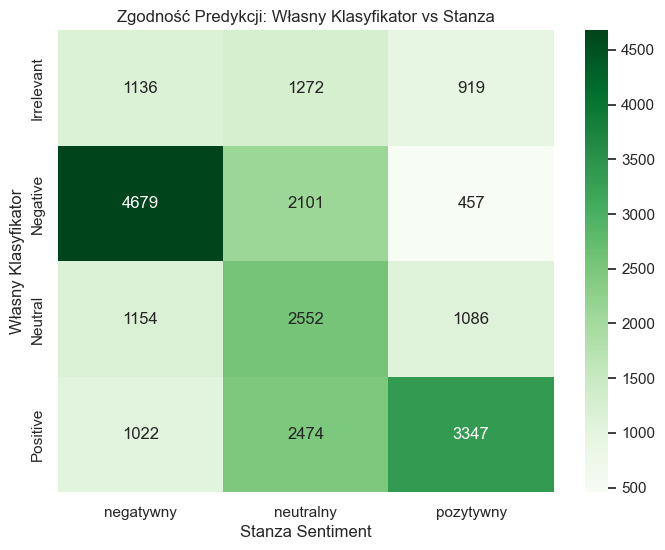


Dokładność własnego klasyfikatora (test): 0.7153
Dokładność Stanza Sentiment (test): 0.0000


In [42]:
# --- KROK 4: Porównanie klasyfikacji własnej z sentymentem Stanza (kod bez zmian) ---
if stanza_nlp and 'df_test_results' in locals() and not df_test_results.empty:
    print("\n--- Porównanie Klasyfikacji: Własny Klasyfikator vs Stanza Sentiment ---")
    print("Analizowanie sentymentu Stanza dla zbioru testowego...")
    df_test_results['stanza_sentiment_pred_label'] = df_test_results['text'].apply(get_stanza_sentiment_label)

    if TARGET_COLUMN == 'sentiment_numeric':
        df_test_results['stanza_sentiment_pred_numeric'] = df_test_results['stanza_sentiment_pred_label'].map(sentiment_map).fillna(1)
        stanza_pred_col = 'stanza_sentiment_pred_numeric'
        print("Mapowano etykiety Stanza na wartości numeryczne.")
    else:
        stanza_pred_col = 'stanza_sentiment_pred_label'
        print("Porównanie na etykietach tekstowych.")

    print("\nPorównanie predykcji na zbiorze testowym:\n", df_test_results[['text', 'true_sentiment', 'custom_classifier_pred', stanza_pred_col]].head())
    print("\nMacierz zgodności: Własny Klasyfikator vs Stanza (na zbiorze testowym)")
    comparison_matrix = pd.crosstab(df_test_results['custom_classifier_pred'], df_test_results[stanza_pred_col],rownames=['Własny Klasyfikator'], colnames=['Stanza Sentiment'])
    print(comparison_matrix)

    plt.figure(figsize=(8, 6)); sns.heatmap(comparison_matrix, annot=True, fmt="d", cmap="Greens"); plt.title('Zgodność Predykcji: Własny Klasyfikator vs Stanza'); plt.show()

    if stanza_pred_col in df_test_results.columns:
         stanza_accuracy = accuracy_score(df_test_results['true_sentiment'], df_test_results[stanza_pred_col])
         print(f"\nDokładność własnego klasyfikatora (test): {accuracy:.4f}")
         print(f"Dokładność Stanza Sentiment (test): {stanza_accuracy:.4f}")
    else: print("\nNie można obliczyć dokładności Stanza.")
else: print("\nNie można przeprowadzić porównania klasyfikatorów.")